In [506]:
import bayesflow as bf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bayesflow.simulation import Prior, Simulator, GenerativeModel
from bayesflow.networks import InvertibleNetwork, DeepSet
from bayesflow.amortizers import AmortizedPosterior
from bayesflow.trainers import Trainer
from sklearn.preprocessing import MinMaxScaler
import winsound

We would like to predict the insurance charge given the information: age, sex, bmi, children, smoker, and region  
Region is a non-informative prior, so we'll disclude it from the model  
### Prior:  
$ Age \sim UniformNormal(18, 99) $  
$ Smokes \sim Binomial(n) $  
$ \beta \sim Normal(0, 10) $  
$ Smokes = 0 : S_0 \sim Normal(0, 1000) $  
$ Smokes = 1 : S_1 \sim Normal(0, 1000) $ may need to increase scale
### Posterior:  
(not complete)  
$ y \sim \beta Age + S_{0,1} $

In [406]:
# Load data
rng = np.random.default_rng(1234)
data = pd.read_csv("insurance.csv", delimiter=',')
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Inspect dataset distributions

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


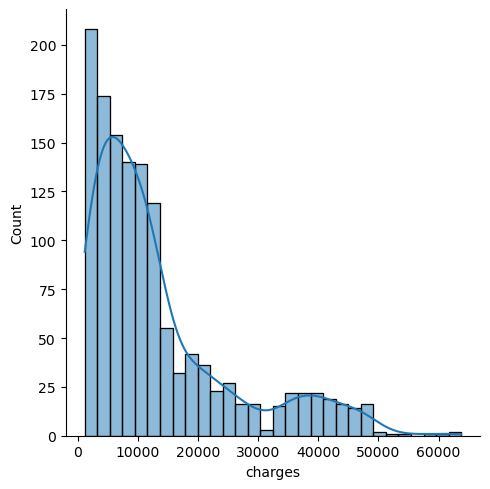

In [407]:
sns.displot(data.charges, kde=True)

In [683]:
def prior_func():
    beta = rng.gamma(10, 1) # age weight
    s = rng.gamma(20, 1) # smokes
    bmi = rng.gamma(10, 1) # bmi weight
    sigma = rng.gamma(10, 4) # y-intercept
    return np.array([beta, s, bmi, sigma])

prior = Prior(prior_fun=prior_func, param_names=["beta", "smokes", "bmi", "sigma"])
# f = prior.plot_prior2d()

In [684]:
def simulate(params, n_obs=300):
    # sample ages
    ages = rng.uniform(18, 65, size=n_obs)
    # sample smokers
    smokes = rng.binomial(1, 0.2, size=n_obs) # 1 -> smoker
    # sample bmi
    bmis = rng.normal(30, 3, size=n_obs)
    # return parent equation w.r.t. parameters
    res = np.zeros((n_obs, len(params-1)))
    for i in range(n_obs):
        res[i,0] = rng.normal(params[0] * ages[i], params[3])
        res[i,1] = rng.normal(params[1] * smokes[i], params[3])
        res[i,2] = rng.normal(params[2] * bmis[i], params[3])
    return res

simulator = Simulator(simulator_fun=simulate)

In [685]:
model = GenerativeModel(prior=prior, simulator=simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 300, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


In [686]:
# debug shape
sim_data = model(4)['sim_data']
sim_data.shape

(4, 300, 4)

In [687]:
summary_net = DeepSet()
inference_net = InvertibleNetwork(
    num_params=len(prior.param_names), 
    num_coupling_layers=4,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": True}
)
amortizer = AmortizedPosterior(inference_net=inference_net, summary_net=summary_net)

In [688]:
trainer = Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [690]:
history = trainer.train_online(epochs=30, iterations_per_epoch=500, batch_size=32, validation_sims=200)
winsound.MessageBeep()

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 500/500 [00:53<00:00,  9.34it/s, Epoch: 1, Iter: 500,Loss: 6.695,Avg.Loss: 7.212,LR: 2.61E-04] 
INFO:root:Validation, Epoch: 1, Loss: 6.025
Training epoch 2: 100%|██████████| 500/500 [00:46<00:00, 10.65it/s, Epoch: 2, Iter: 500,Loss: 5.503,Avg.Loss: 6.142,LR: 8.12E-05]
INFO:root:Validation, Epoch: 2, Loss: 6.330
Training epoch 3: 100%|██████████| 500/500 [00:59<00:00,  8.36it/s, Epoch: 3, Iter: 500,Loss: 5.451,Avg.Loss: 5.609,LR: 2.42E-07]
INFO:root:Validation, Epoch: 3, Loss: 6.364
Training epoch 4: 100%|██████████| 500/500 [00:44<00:00, 11.28it/s, Epoch: 4, Iter: 500,Loss: 5.386,Avg.Loss: 5.501,LR: 0.00E+00]
INFO:root:Validation, Epoch: 4, Loss: 6.360
Training epoch 5: 100%|██████████| 500/500 [00:40<00:00, 12.27it/s, Epoch: 5, Iter: 500,Loss: 5.508,Avg.Loss: 5.522,LR: 0.00E+00]
INFO:root:Validation, Epoch: 5, Loss: 6.360
Training epoch 6: 100%|██████████| 500/500 [00:42<00:00, 11.65it/s, Epoch: 6,

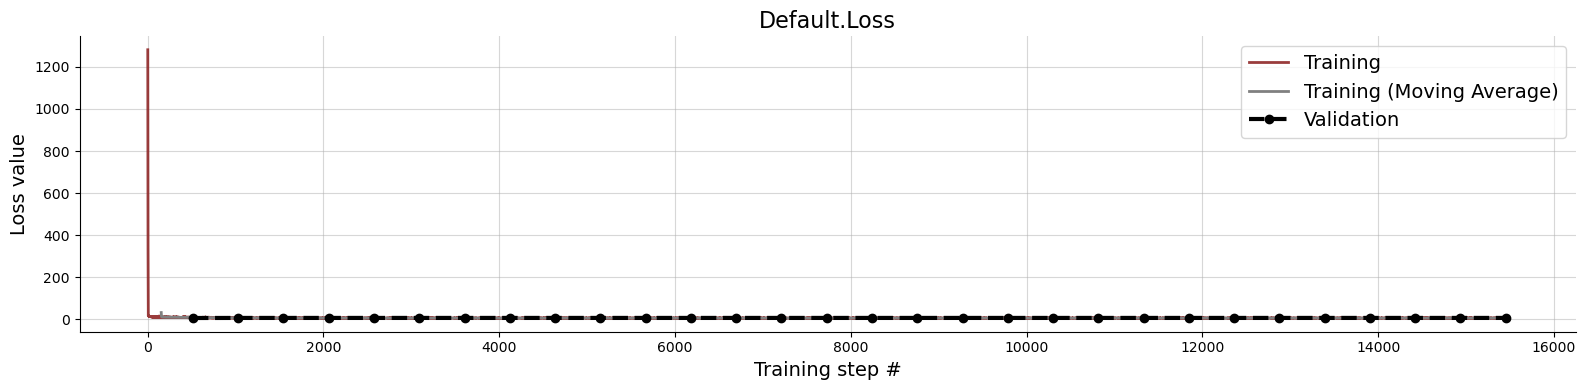

In [691]:
f = bf.diagnostics.plot_losses(history['train_losses'], history['val_losses'], moving_average=True)

dict_keys(['summary_conditions', 'direct_conditions', 'parameters'])
(300, 4)


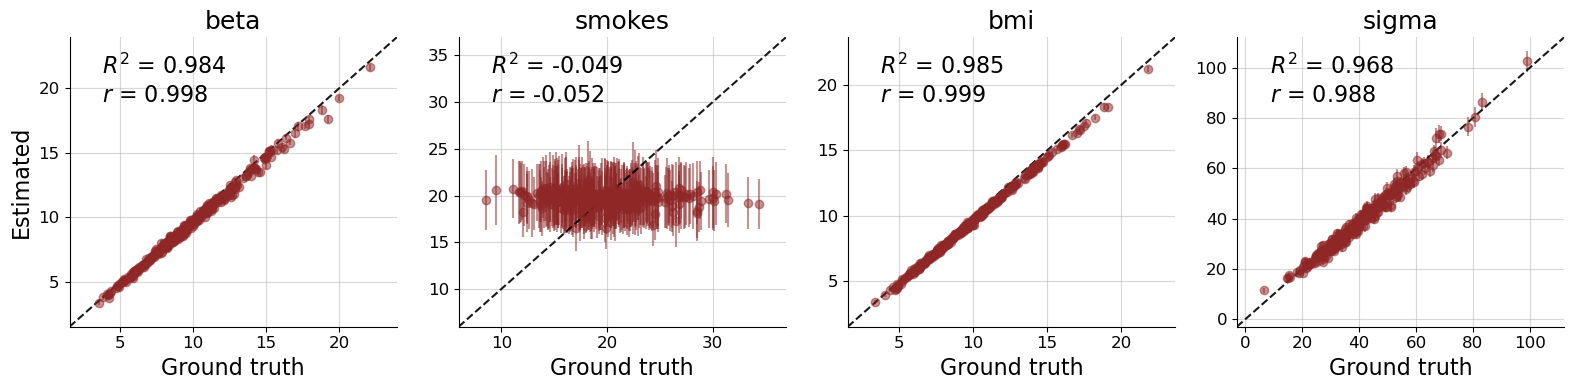

In [692]:
validation_sims = trainer.configurator(model(batch_size=300))
post_samples = amortizer.sample(validation_sims, n_samples=1000)
f = bf.diagnostics.plot_recovery(post_samples, validation_sims['parameters'], param_names=prior.param_names)
print(validation_sims.keys())
params = validation_sims['parameters']
print(params.shape)

C:\Users\grajec\AppData\Local\Temp\ipykernel_5972\2201802219.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training_data = training_data.replace({'yes': 1, 'no': 0})
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\

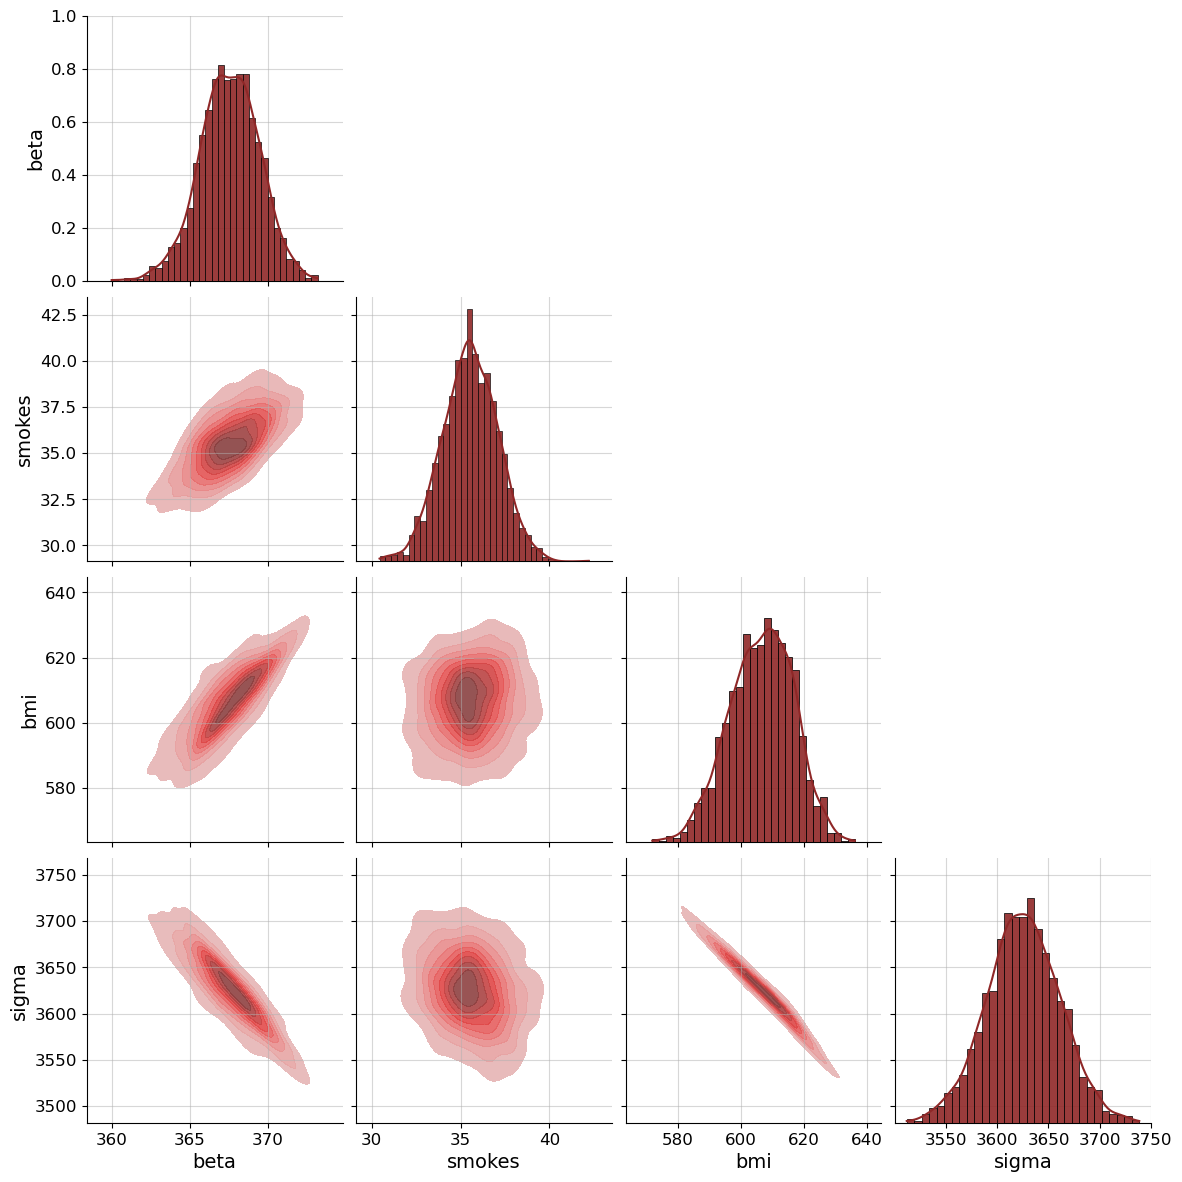

In [693]:
# Inspect trained posterior against real data
training_data = data
training_data = training_data.replace({'yes': 1, 'no': 0})
training_data = training_data.drop(columns=["sex", "region", "children"])
# age, smoke, bmi, charge
training_data = training_data.to_numpy()


post_samples = amortizer.sample({'summary_conditions': np.asarray([training_data])}, n_samples=2000)
f = bf.diagnostics.plot_posterior_2d(post_samples, param_names=prior.param_names)

(2000, 4)


c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='charges', ylabel='Count'>

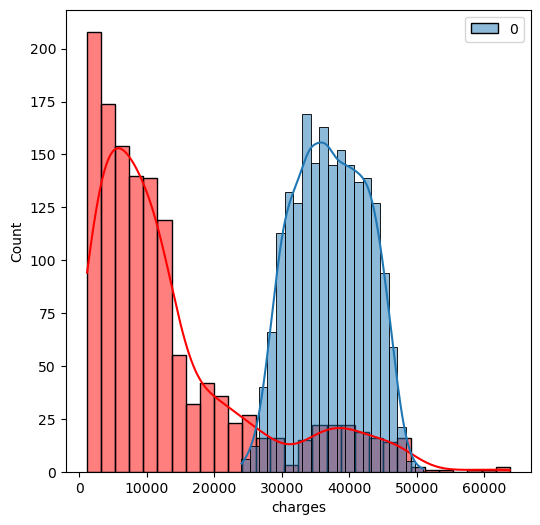

In [694]:
n_samples = post_samples.shape[0]
print(post_samples.shape)


avg_beta = sum(sample[0] for sample in post_samples) / n_samples
avg_s = sum(sample[1] for sample in post_samples) / n_samples
avg_bmi = sum(sample[2] for sample in post_samples) / n_samples
avg_sigma = sum(sample[3] for sample in post_samples) / n_samples

# avg_beta = post_samples[0][0]
# avg_s = post_samples[0][1]
# avg_bmi = post_samples[0][2]
# avg_x = post_samples[0][3]
# avg_sigma = post_samples[0][4]

learned_data = np.zeros((n_samples, 1))
ages = rng.uniform(18, 65, size=n_samples)
bmis = rng.normal(30, 3, size=n_samples)
smokes = rng.binomial(1, 0.2, size=n_samples)
sexes = rng.binomial(1, 0.5, size=n_samples)
for i in range(n_samples):
    learned_data[i] = (avg_beta * ages[i]) + (avg_s * smokes[i]) + (avg_bmi * bmis[i]) + avg_sigma

# for i, row in data.iterrows():
#     age = row.age
#     sex = 0 if row.sex == "female" else 1
#     bmi = row.bmi
#     smoker = 0 if row.smoker == "no" else 1
#     learned_data[i] = (avg_beta * age) + (avg_s * smoker) + (avg_bmi * bmi) + (avg_x * sex) + avg_sigma

fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.histplot(data.charges, color='red', kde=True, ax=ax)
sns.histplot(learned_data, color='blue', kde=True, ax=ax)

<Axes: >

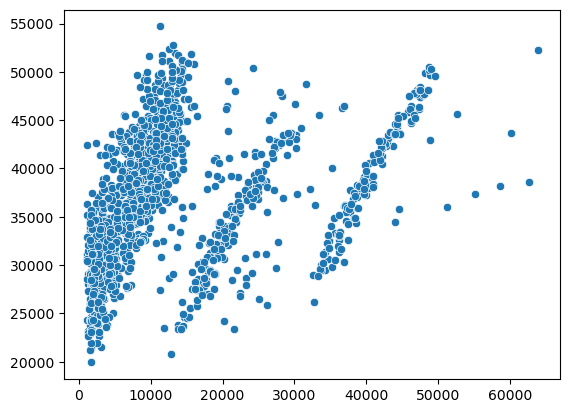

In [695]:
learned_data = np.zeros(len(data.charges))
for i, row in data.iterrows():
    age = row.age
    sex = 0 if row.sex == "female" else 1
    bmi = row.bmi
    smoker = 0 if row.smoker == "no" else 1
    learned_data[i] = (avg_beta * age) + (avg_s * smoker) + (avg_bmi * bmi) + avg_sigma

sns.scatterplot(x=data.charges.to_numpy(), y=learned_data)

<Axes: xlabel='age', ylabel='charges'>

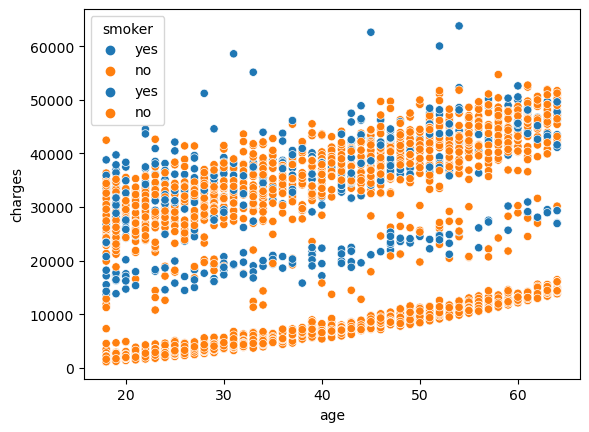

In [696]:
sns.scatterplot(data=data, x='age', y='charges', hue="smoker")
sns.scatterplot(data=data, x='age', y=learned_data, hue="smoker")

In [598]:
x = np.asarray([[1,2],[2,1]])
rng.normal(x, np.eye(2))

array([[1.22737195, 2.        ],
       [2.        , 4.03544706]])

<Axes: xlabel='bmi', ylabel='charges'>

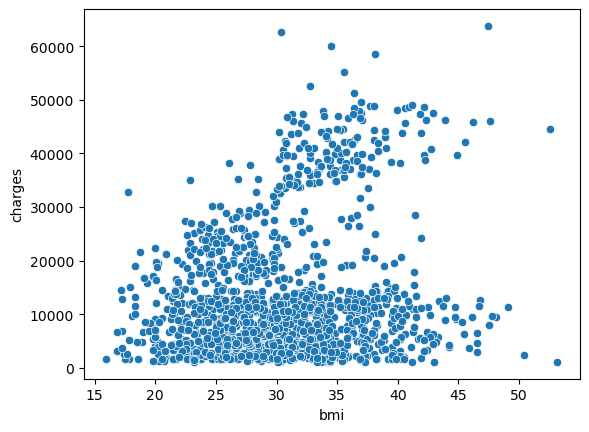

In [421]:
sns.scatterplot(data=data, x='bmi', y='charges')

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='charges', ylabel='Count'>

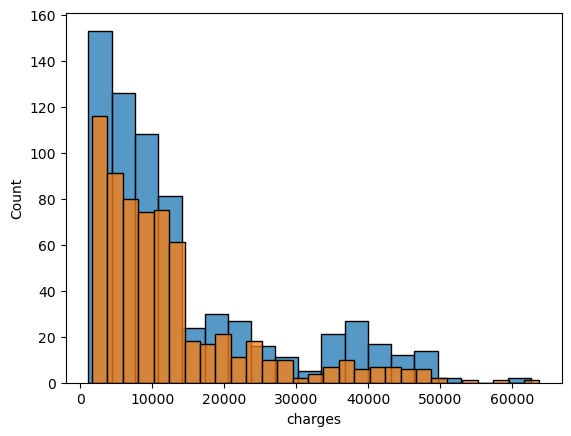

In [422]:
sns.histplot(data[data['sex']=='male']['charges'])
sns.histplot(data[data['sex']=='female']['charges'])

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='charges', ylabel='Count'>

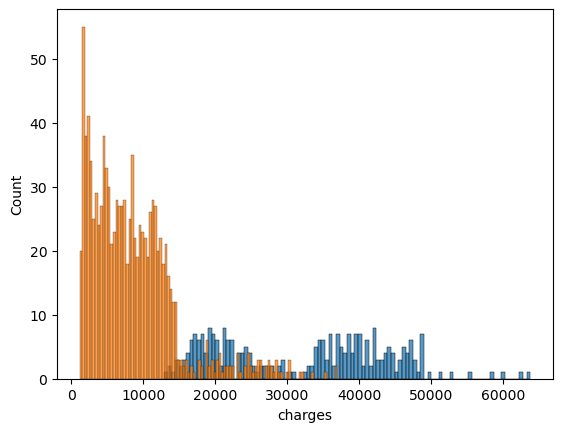

In [423]:
sns.histplot(data[data['smoker']=='yes']['charges'], bins=100)
sns.histplot(data[data['smoker']=='no']['charges'], bins=100)

<Axes: xlabel='children', ylabel='charges'>

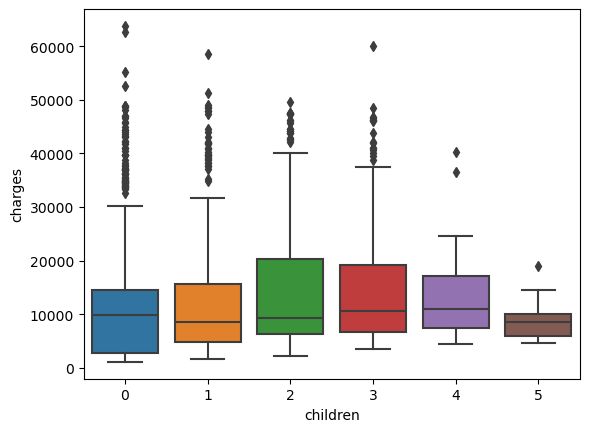

In [424]:
sns.boxplot(data=data, x='children', y='charges')

<Axes: xlabel='region', ylabel='charges'>

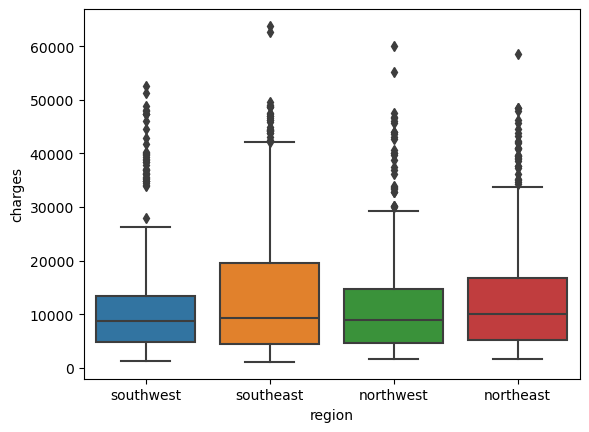

In [425]:
sns.boxplot(data=data, x='region', y='charges')

c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\grajec\miniconda3\envs\final\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

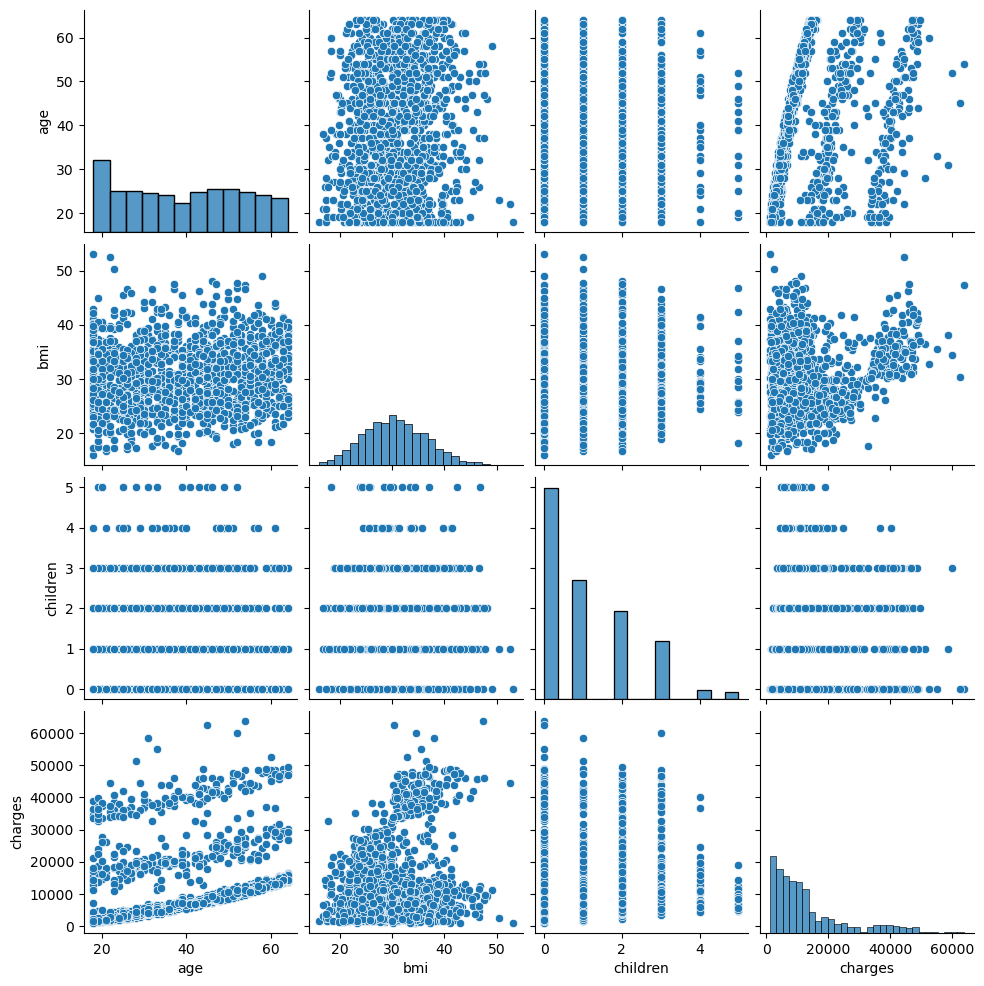

In [426]:
sns.pairplot(data)